In [23]:

import yfinance as yf
import pandas as pd
import numpy as np
import torch
from torch import nn
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [24]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [25]:
# Get stock data
def get_stock_data_yahoo():
    stock = pd.read_csv('data/yahoo_stock.csv')  # Update the file path as needed
    stock.set_index('Date', inplace=True)
    return stock['Close']

In [26]:
# Prepare sequences
def prepare_sequences(data, sequence_length=60):
    scaler = MinMaxScaler(feature_range=(0, 1))

    # Rescale the data
    scaled_data = scaler.fit_transform(data.values.reshape(-1, 1))

    X, y = [], []
    for i in range(len(scaled_data) - sequence_length):
        X.append(scaled_data[i:(i + sequence_length)])
        y.append(scaled_data[i + sequence_length])

    return np.array(X), np.array(y), scaler  # Return scaled data and the scaler

In [35]:
# Define the LSTM model
import torch
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, num_layers=5, output_size=1, dropout_rate=0.2):
        super(LSTMModel, self).__init__()

        # Define the layers
        self.hidden_layer_size = hidden_layer_size
        self.num_layers = num_layers
        self.dropout_rate = dropout_rate

        # LSTM layer (Stacked LSTM)
        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers,
                            batch_first=True,
                            dropout=dropout_rate)

        # Linear layer for output
        self.linear = nn.Linear(hidden_layer_size, output_size)

        # Layer normalization
        self.layer_norm = nn.LayerNorm(hidden_layer_size)

        # Dropout layer to prevent overfitting
        self.dropout = nn.Dropout(p=dropout_rate)

        # Residual connection (optional)
        self.residual_connection = nn.Linear(input_size, hidden_layer_size)

    def forward(self, x):
        # Initialize hidden state and cell state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_layer_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_layer_size).to(device)

        # Forward pass through LSTM
        out, _ = self.lstm(x, (h0, c0))

        # Apply residual connection (optional but can help model performance)
        residual_out = self.residual_connection(x)

        # Apply layer normalization to the LSTM output
        out = self.layer_norm(out[:, -1, :])

        # Apply dropout for regularization
        out = self.dropout(out)

        # Combine the residual output with the LSTM output (optional)
        out = out + residual_out[:, -1, :]

        # Pass through the linear layer
        out = self.linear(out)
        return out


In [36]:
# Train the model
def train_model(model, X_train, y_train, epochs=50, batch_size=32):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion = nn.MSELoss()

    n_batches = len(X_train) // batch_size
    for epoch in range(epochs):
        total_loss = 0
        for i in range(n_batches):
            start_idx = i * batch_size
            end_idx = start_idx + batch_size

            batch_X = torch.tensor(X_train[start_idx:end_idx], dtype=torch.float32).to(device)
            batch_y = torch.tensor(y_train[start_idx:end_idx], dtype=torch.float32).to(device)

            optimizer.zero_grad()
            predictions = model(batch_X)

            loss = criterion(predictions, batch_y.view(-1, 1))
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / n_batches
        print(f"Epoch {epoch+1}, Average Loss: {avg_loss:.4f}")

    return model

In [37]:
# Make predictions
def predict(model, X_test):
    model.eval()
    with torch.no_grad():
        inputs = torch.tensor(X_test, dtype=torch.float32).to(device)
        predictions = model(inputs).cpu().numpy()
    return predictions

In [38]:
# Evaluate predictions
def evaluate_predictions(predictions, actual_values):
    mae = mean_absolute_error(actual_values, predictions)
    rmse = np.sqrt(mean_squared_error(actual_values, predictions))

    print(f"Mean Absolute Error: {mae:.2f}")
    print(f"Root Mean Square Error: {rmse:.2f}")

    return mae, rmse

Epoch 1, Average Loss: 0.1496
Epoch 2, Average Loss: 0.1608
Epoch 3, Average Loss: 0.1050
Epoch 4, Average Loss: 0.0950
Epoch 5, Average Loss: 0.0929
Epoch 6, Average Loss: 0.0863
Epoch 7, Average Loss: 0.0773
Epoch 8, Average Loss: 0.0642
Epoch 9, Average Loss: 0.0581
Epoch 10, Average Loss: 0.0495
Epoch 11, Average Loss: 0.0448
Epoch 12, Average Loss: 0.0375
Epoch 13, Average Loss: 0.0261
Epoch 14, Average Loss: 0.0245
Epoch 15, Average Loss: 0.0192
Epoch 16, Average Loss: 0.0186
Epoch 17, Average Loss: 0.0135
Epoch 18, Average Loss: 0.0115
Epoch 19, Average Loss: 0.0097
Epoch 20, Average Loss: 0.0074
Epoch 21, Average Loss: 0.0063
Epoch 22, Average Loss: 0.0064
Epoch 23, Average Loss: 0.0058
Epoch 24, Average Loss: 0.0057
Epoch 25, Average Loss: 0.0047
Epoch 26, Average Loss: 0.0051
Epoch 27, Average Loss: 0.0043
Epoch 28, Average Loss: 0.0048
Epoch 29, Average Loss: 0.0040
Epoch 30, Average Loss: 0.0036
Epoch 31, Average Loss: 0.0035
Epoch 32, Average Loss: 0.0034
Epoch 33, Average

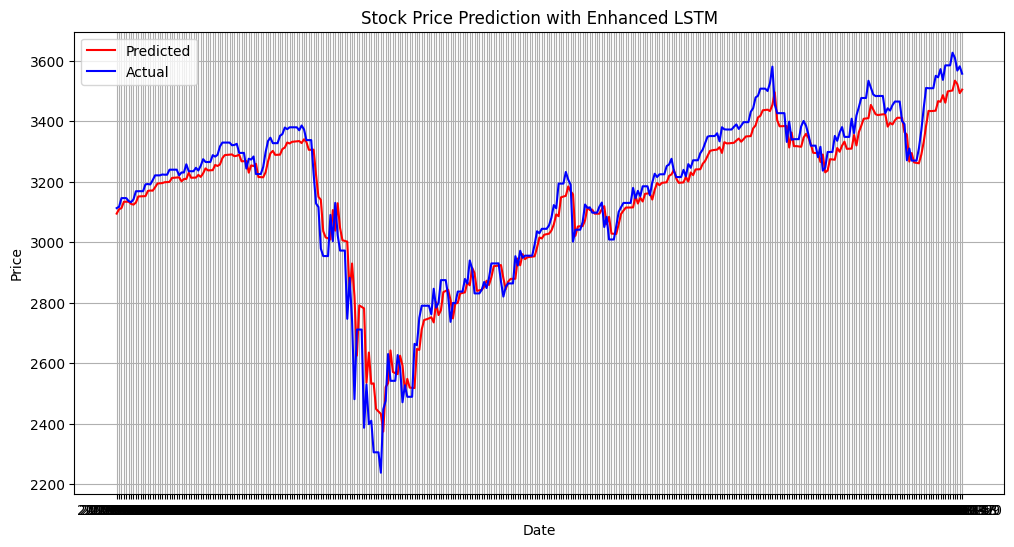

In [40]:
# Main function
def main():
    # Get and prepare data
    data = get_stock_data_yahoo()
    X, y, scaler = prepare_sequences(data)

    # Split data into training and testing sets (80-20 split)
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Convert data to 3D tensors for LSTM (batch_size, sequence_length, num_features)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    model = LSTMModel(input_size=1, hidden_layer_size=100, num_layers=4, dropout_rate=0.3).to(device)

    # Assuming X_train and y_train are prepared
    trained_model = train_model(model, X_train, y_train, epochs=100, batch_size=32)

    # Make predictions
    predictions = predict(trained_model, X_test)

    # Convert predictions back to original scale
    predictions = scaler.inverse_transform(predictions)
    actual_values = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Evaluate predictions
    mae, rmse = evaluate_predictions(predictions, actual_values)

    # Plot results
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 6))
    plt.plot(data.index[-len(predictions):], predictions, label='Predicted', color='red')
    plt.plot(data.index[-len(predictions):], actual_values, label='Actual', color='blue')
    plt.title('Stock Price Prediction with Enhanced LSTM')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()


if __name__ == "__main__":
    main()